# Setup

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/cs224w_project'

/content/drive/.shortcut-targets-by-id/17-Pbrae5VHaYH7c7rM5--KYTzG_0gJXL/cs224w_project


In [ ]:
pip install torch

In [ ]:
pip install --upgrade tensorflow tensorboard

In [ ]:
pip install torch_geometric

In [ ]:
!pip install pytorch_lightning

In [ ]:
import torch
import torch_geometric
from torch_geometric.data import HeteroData

In [ ]:
# replace topic and decade with your choice
topic = 'labor'
decade = 60

# hyperparameters for the model training
layers = 1
sizes = [(128, 128)] # (64, 32),
temperatures = [0.08, 0.12]
alphas = [1, 10]
num_layers = 1
lr = 0.005

In [ ]:
# create directory where we're going to save our trained embeddings
import os

folder_name = f"karsen_redo/HETEROGNN/{topic}_{decade}{decade+10}"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [ ]:
# replace the path to the saved HeteroData graph file as needed
data = torch.load(f'karsen_redo/HETEROGNN/{topic}_{decade}{decade+10}_hetgraph.pt')

In [ ]:
# standardize the node features

tensor = data['newspaper'].x
mean = tensor.mean()
std = tensor.std()

data['newspaper'].x = (tensor - mean) / std

tensor = data['article'].x
mean = tensor.mean()
std = tensor.std()

data['article'].x = (tensor - mean) / std

## GATConv Model Init and Training Loop

In [ ]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch_geometric.nn import HeteroConv, GCNConv, GraphConv, GATConv, SAGEConv, to_hetero, Linear
from torch_geometric.utils import negative_sampling

"""
HeteroGNN model with GATConv layers for UNSUPERVISED REPRESENTATION LEARNING.
Takes as input the hidden dimension, output dimension, and optional tuning hyperparameters.
Uses a mixed geometric negative sampling loss and feature based contrastive loss to
balance geometric information with feature information.
"""
class HeteroGNN(pl.LightningModule):
    def __init__(self, hidden_channels, out_channels, num_layers=1, lr=0.005, temperature=0.07, alpha=1):
        super().__init__()

        # loss discrimination parameters
        self.temperature = temperature
        self.alpha = alpha

        # conv layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('article', 'published_in', 'newspaper'): GATConv((-1, -1), hidden_channels, add_self_loops=False),
                ('newspaper', 'publishes', 'article'): GATConv((-1, -1), hidden_channels, add_self_loops=False)
            }, aggr='sum')
            self.convs.append(conv)

        # normalization after the conv layer
        self.batch_norm_news = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm_art = torch.nn.BatchNorm1d(hidden_channels)

        # final linear layer
        self.lin_news = Linear(hidden_channels, out_channels)
        self.lin_art = Linear(hidden_channels, out_channels)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        self.losses = {'train': [], 'link': [], 'feature': []}

        # feature projection, to be used in the feature loss function
        self.feature_proj = Linear(data['newspaper'].x.shape[1], out_channels)


    def init_weights(self, m):
        """ Initialize weights using Xavier uniform distribution. """
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)

        elif isinstance(m, SAGEConv) or isinstance(m, GATConv):
            # Xavier initialization
            torch.nn.init.xavier_uniform_(m.lin_l.weight)
            torch.nn.init.xavier_uniform_(m.lin_r.weight)
            if m.lin_l.bias is not None:
                torch.nn.init.zeros_(m.lin_l.bias)
            if m.lin_r.bias is not None:
                torch.nn.init.zeros_(m.lin_r.bias)


    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

            for key in x_dict:
                if key == 'newspaper':
                    x_dict[key] = self.batch_norm_news(x_dict[key])  # BatchNorm for 'newspaper' nodes
                elif key == 'article':
                    x_dict[key] = self.batch_norm_art(x_dict[key])  # BatchNorm for 'article' nodes
                x_dict[key] = x_dict[key].relu()  # Apply ReLU activation after BatchNorm

        # final out proj
        out_dict = {}
        for key, x in x_dict.items():
            if key == 'newspaper':
                out_dict[key] = self.lin_news(x)
            elif key == 'article':
                out_dict[key] = self.lin_art(x)

        return out_dict


    def training_step(self, batch, batch_idx):
        # Access x_dict and edge_index_dict directly from the batch (graph)
        x_dict, edge_index_dict = batch.x_dict, batch.edge_index_dict

        # Focus on article --> newspaper message type
        src, e, dst = 'article', 'published_in', 'newspaper'
        message = (src, e, dst)
        num_article = len(edge_index_dict[message][0].unique())
        num_newspaper = len(edge_index_dict[message][1].unique())

        # Learn node embeddings
        z_dict = self.forward(x_dict, edge_index_dict) # keys: 'newspaper', 'article'

        # Positive edges: We'll sample positive edges based on edge_index_dict
        pos_edge_index = edge_index_dict[message]

        edge_index = batch.edge_index_dict[message]

        # Negative edges: We'll sample based on what's not in the edge_index
        neg_edge_index = negative_sampling(
            edge_index=edge_index,
            num_nodes=(num_article, num_newspaper),
            num_neg_samples=pos_edge_index.size(1)  # same number of negative and positive samples
        )

        # Sim function is cosine similarity (geometric)
        pos_pred = F.cosine_similarity(
            z_dict[src][pos_edge_index[0]],
            z_dict[dst][pos_edge_index[1]]
        )

        neg_pred = F.cosine_similarity(
            z_dict[src][neg_edge_index[0]],
            z_dict[dst][neg_edge_index[1]]
        )

        # Binary cross-entropy loss (geometric)
        pos_loss = F.binary_cross_entropy_with_logits(pos_pred, torch.ones_like(pos_pred))
        neg_loss = F.binary_cross_entropy_with_logits(neg_pred, torch.zeros_like(neg_pred))

        link_loss = pos_loss + neg_loss

        # Feature-based contrastive loss for newspaper nodes
        features = self.feature_proj(x_dict['newspaper'])
        feature_sim = F.cosine_similarity(features.unsqueeze(1),
                                        features.unsqueeze(0)) / self.temperature
        emb_sim = F.cosine_similarity(z_dict['newspaper'].unsqueeze(1),
                                    z_dict['newspaper'].unsqueeze(0)) / self.temperature

        contrastive_loss = F.kl_div(F.log_softmax(emb_sim, dim=-1),
                                  F.softmax(feature_sim, dim=-1))

        # alpha balances the consideration of the feature loss vs the geometric loss
        loss = link_loss + self.alpha * contrastive_loss

        self.log('train_loss', loss)
        print(f"Train_loss = {loss.item()}, link_loss={link_loss.item()}, contrastive_loss={contrastive_loss.item()}")
        self.losses['train'].append(loss.item())
        self.losses['link'].append(link_loss.item())
        self.losses['feature'].append(contrastive_loss.item())
        return loss

    def configure_optimizers(self):
        return self.optimizer

In [ ]:
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

"""
Trains a new HeteroGNN model on the given Heterodata graph.
Takes in optional hyperparameters for the model.
Uses PyTorch Lightning for easy training and logging, as well as early stopping.
Returns final embeddings, the model, and training losses.
"""
def train_link_prediction_gnn(graph, hidden_size=64, out_size=32, num_layers=1, lr=0.005):
    # Initialize model
    model = HeteroGNN(hidden_size, out_size, num_layers=num_layers, lr=lr)

    # Convert graph to a DataLoader (since there's only one graph, we wrap it in a list)
    train_loader = DataLoader([graph], batch_size=1) # device

    # Lightning Trainer, with early stopping and logging
    trainer = pl.Trainer(
        max_epochs=100,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        log_every_n_steps=5,  # Log every 5 steps
        callbacks=[
            pl.callbacks.EarlyStopping(monitor='train_loss', patience=10),
            pl.callbacks.ModelCheckpoint(monitor='train_loss')
        ]
    )

    trainer.fit(model, train_dataloaders=train_loader)

    # Return final node embeddings
    with torch.no_grad():
        final_embeddings = model(graph.x_dict, graph.edge_index_dict)

    return final_embeddings, model, model.losses


In [ ]:
graph = data

conv = 'gat' # used in save file path for easy retrieval later

# generate and save embeddings for all models within the hyperparameter grid search
for hidden_size, out_size in sizes:
    for temperature in temperatures:
        for alpha in alphas:
          print(f'\n HIDDEN SIZE {hidden_size}, OUTPUT SIZE {out_size}, TEMPERATURE {temperature}, ALPHA {alpha}')
          # replace the path to whereever you wish to save the graph model embeddings
          path_name = f'karsen_redo/HETEROGNN/{topic}_{decade}{decade+10}/het_{conv}_t{temperature}_a{alpha}_h{hidden_size}_o{out_size}_l{num_layers}_lr{lr*1000}'

          # Train the GNN and get embeddings
          node_embeddings, trained_model, losses = train_link_prediction_gnn(graph, hidden_size, out_size, num_layers, lr)

          # Save embeddings
          torch.save(node_embeddings, f'{path_name}.pt')
          torch.save(losses, f'{path_name}_losses.pt')

          # Loss plot for diagnostics
          # the losses log is saved at the same path, so you can easily retrieve it as well later
          plt.plot(losses['train'], label='Total')
          plt.plot(losses['link'], label='Link')
          plt.plot(losses['feature'], label='Feature')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.title(f'Training Loss Over Epochs')
          plt.legend()
          plt.savefig(f'{path_name}.png')
          plt.show()

# SAGEConv Model Init and Training

In [ ]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from torch_geometric.nn import HeteroConv, GCNConv, GraphConv, GATConv, SAGEConv, to_hetero, Linear
from torch_geometric.utils import negative_sampling

"""
HeteroGNN model with SAGEConv layers for UNSUPERVISED REPRESENTATION LEARNING.
Takes as input the hidden dimension, output dimension, and optional tuning hyperparameters.
Uses a mixed geometric negative sampling loss and feature based contrastive loss to
balance geometric information with feature information.
"""
class HeteroGNN(pl.LightningModule):
    def __init__(self, hidden_channels, out_channels, num_layers=1, lr=0.005, temperature=0.07, alpha=1):
        super().__init__()

        # loss discrimination parameters
        self.temperature = temperature
        self.alpha = alpha

        # conv layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('article', 'published_in', 'newspaper'): SAGEConv((-1, -1), hidden_channels),
                ('newspaper', 'publishes', 'article'): SAGEConv((-1, -1), hidden_channels)
            }, aggr='sum')
            self.convs.append(conv)

        # normalization after the conv layer
        self.batch_norm_news = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm_art = torch.nn.BatchNorm1d(hidden_channels)

        # final linear layer
        self.lin_news = Linear(hidden_channels, out_channels)
        self.lin_art = Linear(hidden_channels, out_channels)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        self.losses = {'train': [], 'link': [], 'feature': []}

        # feature projection, to be used in the feature loss function
        self.feature_proj = Linear(data['newspaper'].x.shape[1], out_channels)


    def init_weights(self, m):
        """ Initialize weights using Xavier uniform distribution. """
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)

        elif isinstance(m, SAGEConv) or isinstance(m, GATConv):
            # Xavier initialization
            torch.nn.init.xavier_uniform_(m.lin_l.weight)
            torch.nn.init.xavier_uniform_(m.lin_r.weight)
            if m.lin_l.bias is not None:
                torch.nn.init.zeros_(m.lin_l.bias)
            if m.lin_r.bias is not None:
                torch.nn.init.zeros_(m.lin_r.bias)


    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

            for key in x_dict:
                if key == 'newspaper':
                    x_dict[key] = self.batch_norm_news(x_dict[key])  # BatchNorm for 'newspaper' nodes
                elif key == 'article':
                    x_dict[key] = self.batch_norm_art(x_dict[key])  # BatchNorm for 'article' nodes
                x_dict[key] = x_dict[key].relu()  # Apply ReLU activation after BatchNorm

        # final out proj
        out_dict = {}
        for key, x in x_dict.items():
            if key == 'newspaper':
                out_dict[key] = self.lin_news(x)
            elif key == 'article':
                out_dict[key] = self.lin_art(x)

        return out_dict


    def training_step(self, batch, batch_idx):
        # Access x_dict and edge_index_dict directly from the batch (graph)
        x_dict, edge_index_dict = batch.x_dict, batch.edge_index_dict

        # Focus on article --> newspaper message type
        src, e, dst = 'article', 'published_in', 'newspaper'
        message = (src, e, dst)
        num_article = len(edge_index_dict[message][0].unique())
        num_newspaper = len(edge_index_dict[message][1].unique())

        # Learn node embeddings
        z_dict = self.forward(x_dict, edge_index_dict) # keys: 'newspaper', 'article'

        # Positive edges: We'll sample positive edges based on edge_index_dict
        pos_edge_index = edge_index_dict[message]

        edge_index = batch.edge_index_dict[message]

        # Negative edges: We'll sample based on what's not in the edge_index
        neg_edge_index = negative_sampling(
            edge_index=edge_index,
            num_nodes=(num_article, num_newspaper),
            num_neg_samples=pos_edge_index.size(1)  # same number of negative and positive samples
        )

        # Sim function is cosine similarity (geometric)
        pos_pred = F.cosine_similarity(
            z_dict[src][pos_edge_index[0]],
            z_dict[dst][pos_edge_index[1]]
        )

        neg_pred = F.cosine_similarity(
            z_dict[src][neg_edge_index[0]],
            z_dict[dst][neg_edge_index[1]]
        )

        # Binary cross-entropy loss (geometric)
        pos_loss = F.binary_cross_entropy_with_logits(pos_pred, torch.ones_like(pos_pred))
        neg_loss = F.binary_cross_entropy_with_logits(neg_pred, torch.zeros_like(neg_pred))

        link_loss = pos_loss + neg_loss

        # Feature-based contrastive loss for newspaper nodes
        features = self.feature_proj(x_dict['newspaper'])
        feature_sim = F.cosine_similarity(features.unsqueeze(1),
                                        features.unsqueeze(0)) / self.temperature
        emb_sim = F.cosine_similarity(z_dict['newspaper'].unsqueeze(1),
                                    z_dict['newspaper'].unsqueeze(0)) / self.temperature

        contrastive_loss = F.kl_div(F.log_softmax(emb_sim, dim=-1),
                                  F.softmax(feature_sim, dim=-1))

        # alpha balances the consideration of the feature loss vs the geometric loss
        loss = link_loss + self.alpha * contrastive_loss

        self.log('train_loss', loss)
        print(f"Train_loss = {loss.item()}, link_loss={link_loss.item()}, contrastive_loss={contrastive_loss.item()}")
        self.losses['train'].append(loss.item())
        self.losses['link'].append(link_loss.item())
        self.losses['feature'].append(contrastive_loss.item())
        return loss

    def configure_optimizers(self):
        return self.optimizer


 HIDDEN SIZE 128, OUTPUT SIZE 128, TEMPERATURE 0.08, ALPHA 10


<ipython-input-23-2de375e03b70>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(f'karsen_redo/HETEROGNN/{topic}_{decade}{decade+10}_hetgraph.pt')
INFO:p

Training: |          | 0/? [00:00<?, ?it/s]

Train_loss = 1.4308819770812988, link_loss=1.389404058456421, contrastive_loss=0.041477881371974945
Train_loss = 1.3612594604492188, link_loss=1.3212438821792603, contrastive_loss=0.04001563414931297
Train_loss = 1.3467804193496704, link_loss=1.3049651384353638, contrastive_loss=0.04181522876024246
Train_loss = 1.340641736984253, link_loss=1.3029987812042236, contrastive_loss=0.03764299675822258
Train_loss = 1.3376671075820923, link_loss=1.3001267910003662, contrastive_loss=0.03754027187824249
Train_loss = 1.3332974910736084, link_loss=1.2955374717712402, contrastive_loss=0.03775995969772339
Train_loss = 1.3289716243743896, link_loss=1.290473461151123, contrastive_loss=0.038498204201459885
Train_loss = 1.3213939666748047, link_loss=1.2825040817260742, contrastive_loss=0.03888987377285957
Train_loss = 1.3282643556594849, link_loss=1.2876602411270142, contrastive_loss=0.040604084730148315
Train_loss = 1.3223167657852173, link_loss=1.28334379196167, contrastive_loss=0.038973014801740646
T

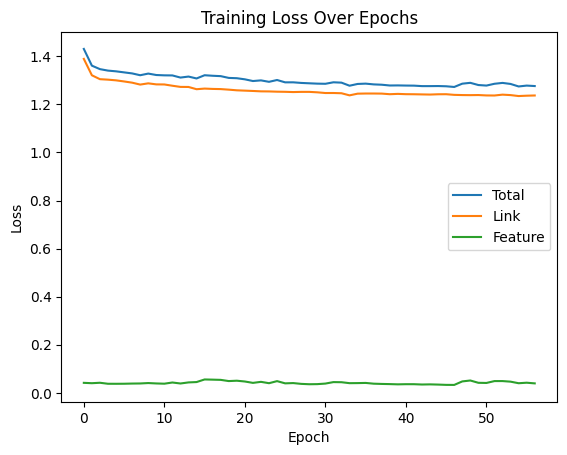

In [ ]:
conv = 'sage'

# generate and save embeddings for all models within the hyperparameter grid search
# we iterate over the same hyperparameter set as for the GATConv model
for hidden_size, out_size in sizes:
    for temperature in temperatures:
        for alpha in alphas:
          print(f'\n HIDDEN SIZE {hidden_size}, OUTPUT SIZE {out_size}, TEMPERATURE {temperature}, ALPHA {alpha}')
          path_name = f'karsen_redo/HETEROGNN/{topic}_{decade}{decade+10}/het_{conv}_t{temperature}_a{alpha}_h{hidden_size}_o{out_size}_l{num_layers}_lr{lr*1000}'

          # Train the GNN and get embeddings
          node_embeddings, trained_model, losses = train_link_prediction_gnn(graph, hidden_size, out_size, num_layers, lr)

          # Save embeddings
          torch.save(node_embeddings, f'{path_name}.pt')
          torch.save(losses, f'{path_name}_losses.pt')

          plt.plot(losses['train'], label='Total')
          plt.plot(losses['link'], label='Link')
          plt.plot(losses['feature'], label='Feature')
          plt.xlabel('Epoch')
          plt.ylabel('Loss')
          plt.title(f'Training Loss Over Epochs')
          plt.legend()
          plt.savefig(f'{path_name}.png')
          plt.show()